In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
base_path = '/content/drive/MyDrive/MainDataset'
train_dir = os.path.join(base_path, 'Train')
val_dir = os.path.join(base_path, 'Test')
test_dir = os.path.join(base_path, 'Validation')
print("Train folders:", os.listdir(train_dir))


Train folders: ['black_sigatoka', 'potassium_deficiency', 'panama_disease', 'healthy', 'yellow_sigatoka']


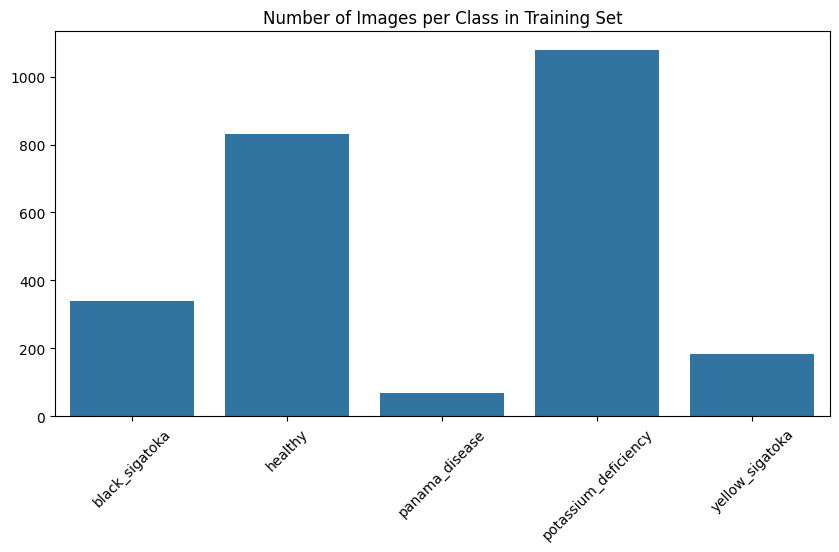

In [ ]:

import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = pathlib.Path(train_dir)
class_names = sorted(item.name for item in data_dir.glob("*/") if item.is_dir())

class_counts = {cls: len(list(data_dir.glob(f"{cls}/*.jpg"))) for cls in class_names}
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Number of Images per Class in Training Set")
plt.show()


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True,
    width_shift_range=0.1, height_shift_range=0.1)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_data = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
test_data = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 2504 images belonging to 5 classes.
Found 539 images belonging to 5 classes.
Found 573 images belonging to 5 classes.


In [ ]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def build_model(learning_rate=0.0001, dropout_rate=0.3):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(len(class_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import os

# Path to save the full model (with .keras extension)
full_model_path = "/content/drive/MyDrive/full_mobilenet_model.keras"

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop]
)

# ✅ Save the full model in Keras format (architecture + weights)
model.save(full_model_path)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9389 - loss: 0.1628 - val_accuracy: 0.7421 - val_loss: 0.7609
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9515 - loss: 0.1413 - val_accuracy: 0.7403 - val_loss: 0.7012
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.9549 - loss: 0.1239 - val_accuracy: 0.7458 - val_loss: 0.7245
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9557 - loss: 0.1307 - val_accuracy: 0.7440 - val_loss: 0.5962
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.9580 - loss: 0.1211 - val_accuracy: 0.7514 - val_loss: 0.6405
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.9619 - loss: 0.0931 - val_accuracy: 0.7570 - val_loss: 0.6714
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9581 - loss: 0.1136 - val_accuracy: 0.7570 - val_loss: 0.7119
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.9690 - loss: 0.0937 - val_accuracy: 0.7495 - v

In [ ]:
!pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
from tensorflow import keras

# Load .keras model
model = keras.models.load_model("/content/drive/MyDrive/full_mobilenet_model.keras")

# Re-save it as .h5
model.save("/content/drive/MyDrive/full_mobilenet_model.h5")


In [ ]:
!tensorflowjs_converter \
  --input_format=keras \
  /content/drive/MyDrive/full_mobilenet_model.h5 \
  /content/drive/MyDrive/tfjs_model


2025-05-31 13:23:49.208996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748697829.237361   32167 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748697829.245277   32167 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
xplt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

NameError: name 'xplt' is not defined

18/18 ━━━━━━━━━━━━━━━━━━━━ 334s 19s/step
                      precision    recall  f1-score   support

      black_sigatoka       0.53      0.59      0.56        71
             healthy       0.75      1.00      0.86       227
      panama_disease       0.85      0.65      0.73        17
potassium_deficiency       0.92      0.55      0.69       222
     yellow_sigatoka       0.38      0.50      0.43        36

            accuracy                           0.73       573
           macro avg       0.69      0.66      0.65       573
        weighted avg       0.77      0.73      0.72       573



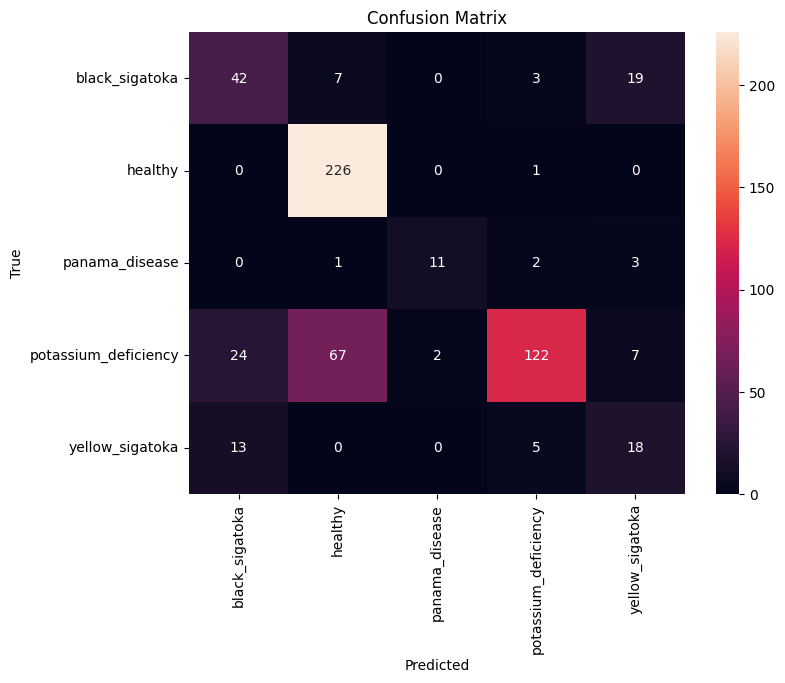

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

pred = model.predict(test_data)
y_pred = np.argmax(pred, axis=1)
y_true = test_data.classes

print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Saving POTASSIUM 0001 81 .jpg to POTASSIUM 0001 81 .jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: potassium_deficiency (35.97%)


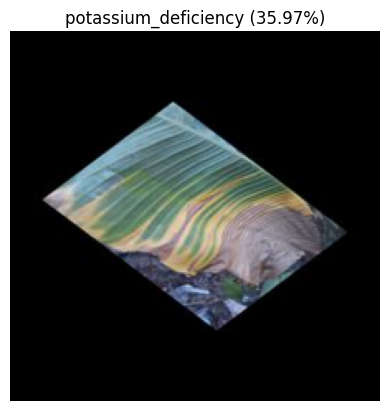

In [ ]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
from PIL import Image

model = load_model('best_mobilenet_model.h5')

uploaded = files.upload()
for img_path in uploaded.keys():
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    print(f"Predicted Class: {predicted_class} ({confidence:.2f}%)")
    plt.imshow(img)
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()


Saving IMG_20241104_191920.jpg to IMG_20241104_191920.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: healthy (93.20%)


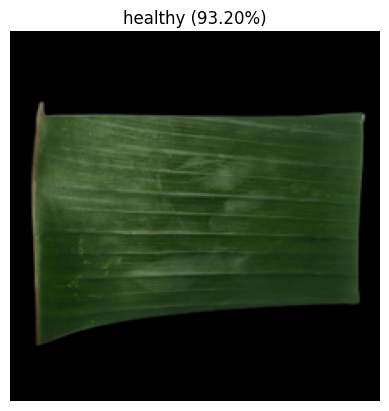

In [ ]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
from PIL import Image

model = load_model('best_mobilenet_model.h5')

uploaded = files.upload()
for img_path in uploaded.keys():
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    print(f"Predicted Class: {predicted_class} ({confidence:.2f}%)")
    plt.imshow(img)
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()


Saving YELLOW_SIGATOKA 0001 200 .jpg to YELLOW_SIGATOKA 0001 200 .jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: yellow_sigatoka (55.58%)


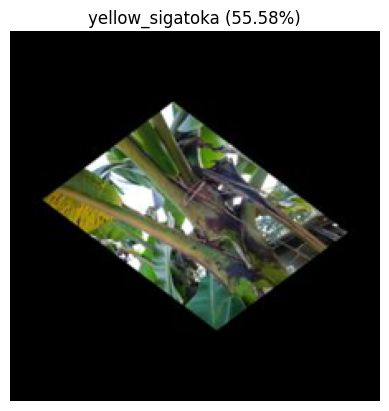

In [ ]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
from PIL import Image

model = load_model('best_mobilenet_model.h5')

uploaded = files.upload()
for img_path in uploaded.keys():
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    print(f"Predicted Class: {predicted_class} ({confidence:.2f}%)")
    plt.imshow(img)
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()


Saving BLACK_SIGATOKA 0001 394 .jpg to BLACK_SIGATOKA 0001 394 .jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: black_sigatoka (73.47%)


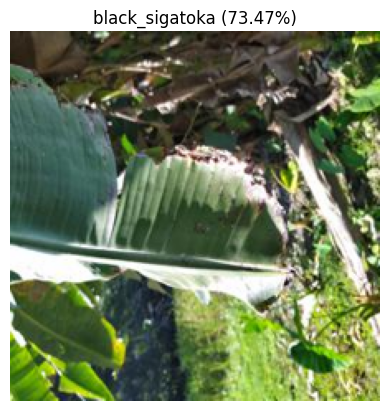

In [ ]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
from PIL import Image

model = load_model('best_mobilenet_model.h5')

uploaded = files.upload()
for img_path in uploaded.keys():
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    print(f"Predicted Class: {predicted_class} ({confidence:.2f}%)")
    plt.imshow(img)
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()


In [ ]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
from PIL import Image

model = load_model('best_mobilenet_model.h5')

uploaded = files.upload()
for img_path in uploaded.keys():
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    print(f"Predicted Class: {predicted_class} ({confidence:.2f}%)")
    plt.imshow(img)
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()
